<a href="https://colab.research.google.com/github/devbravo/Machine-Learning-Projects/blob/main/Music_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ! pip install scikeras

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
! kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification


100% 1.21G/1.21G [00:45<00:00, 28.5MB/s]
100% 1.21G/1.21G [00:45<00:00, 28.4MB/s]


In [4]:
! unzip gtzan-dataset-music-genre-classification
! rm -r gtzan-dataset-music-genre-classification.zip


Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues.00014.wa

In [5]:
import os
import math
import json
import librosa, librosa.display
import soundfile
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import to_categorical
# from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder



In [6]:
filepath = '/content/Data/genres_original/'
json_path = '/content'

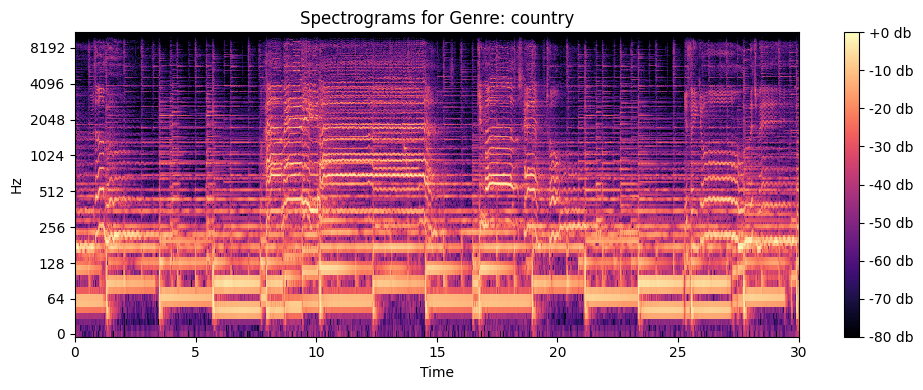

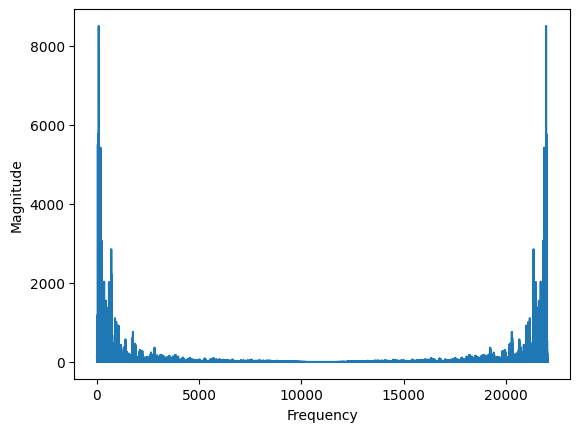

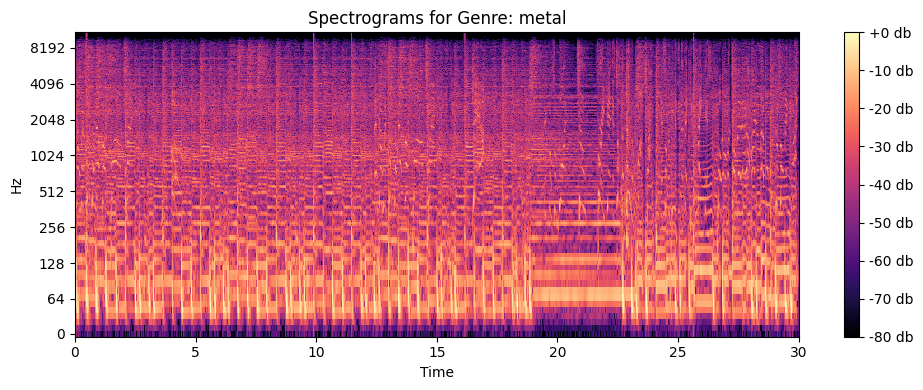

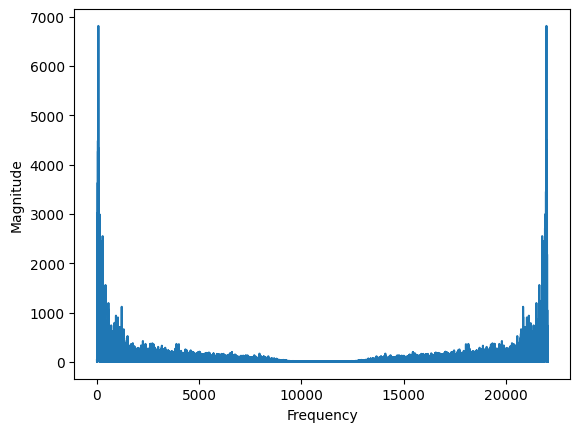

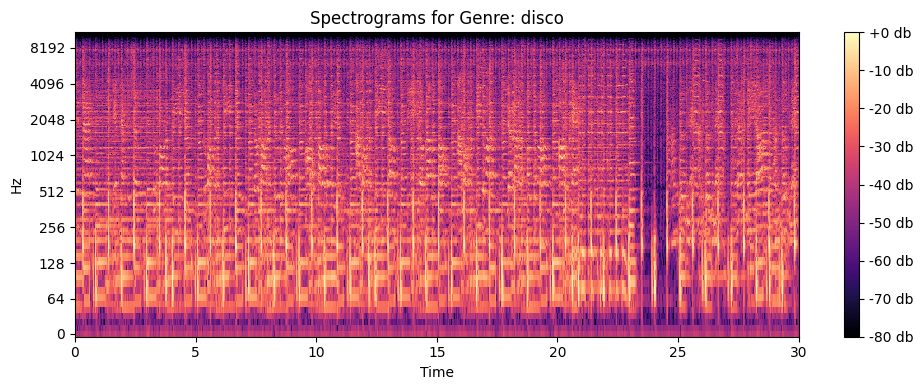

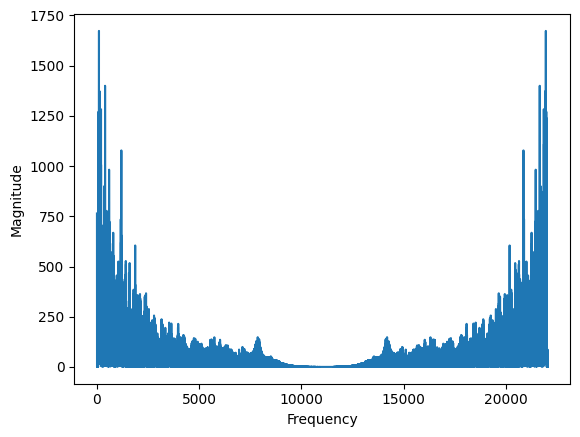

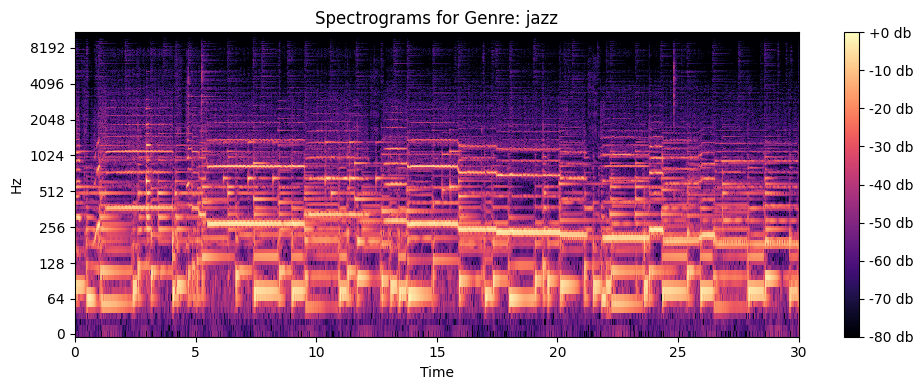

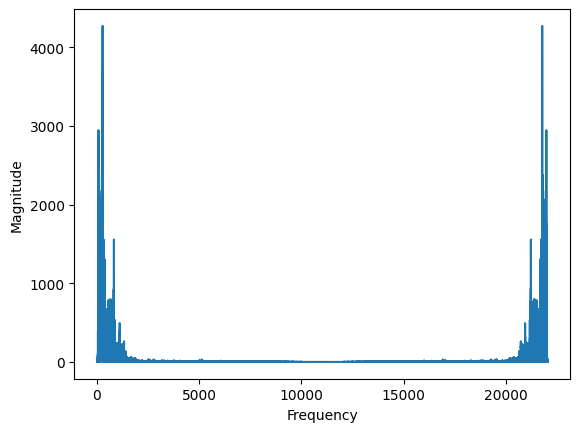

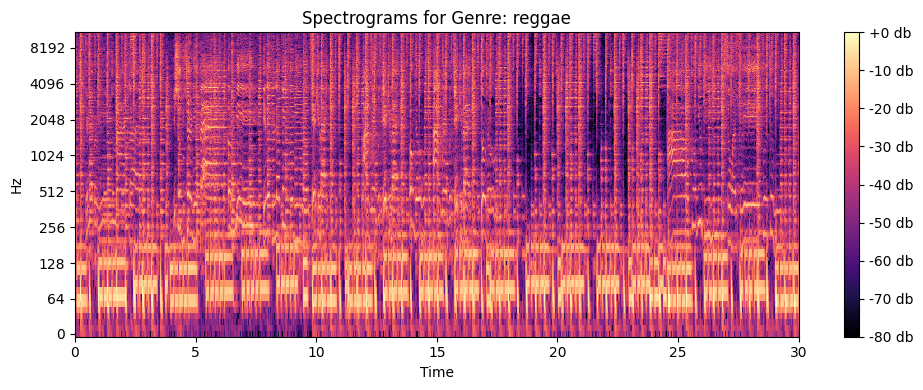

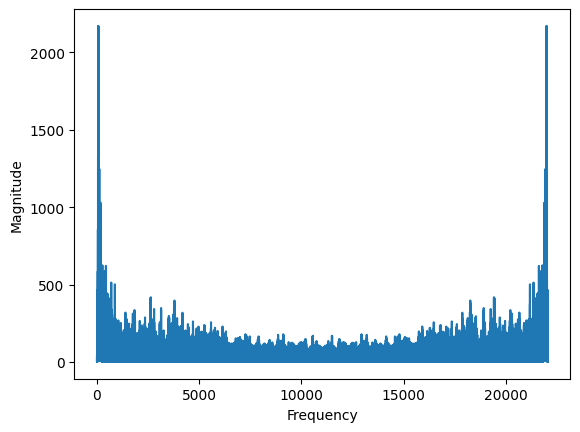

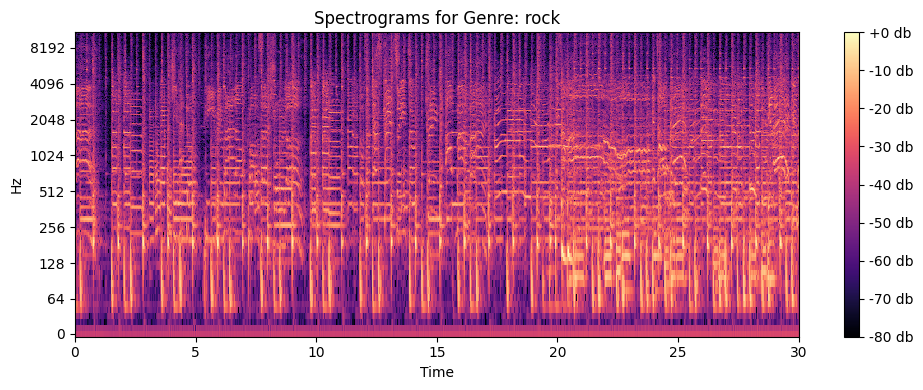

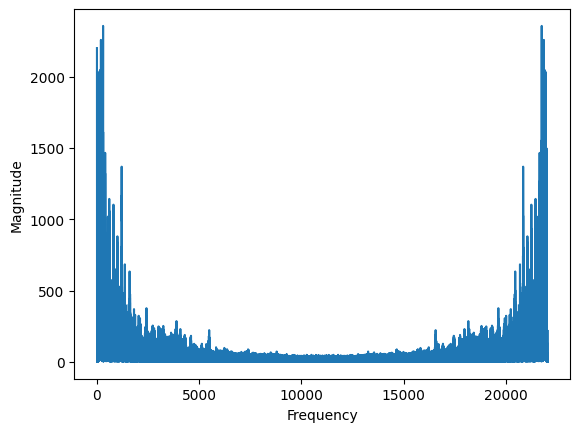

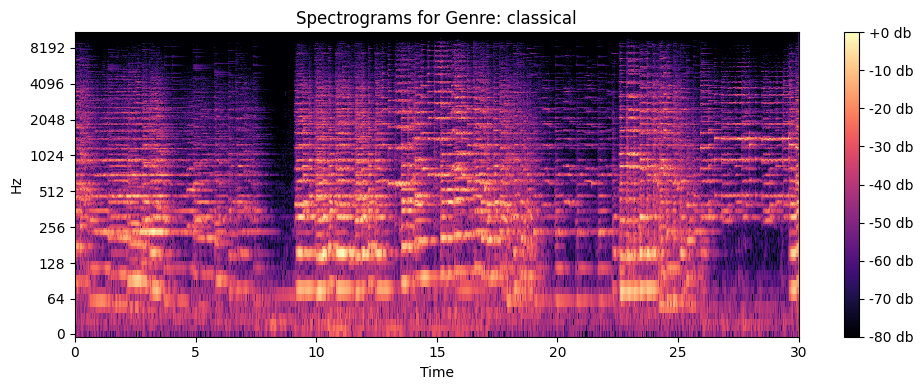

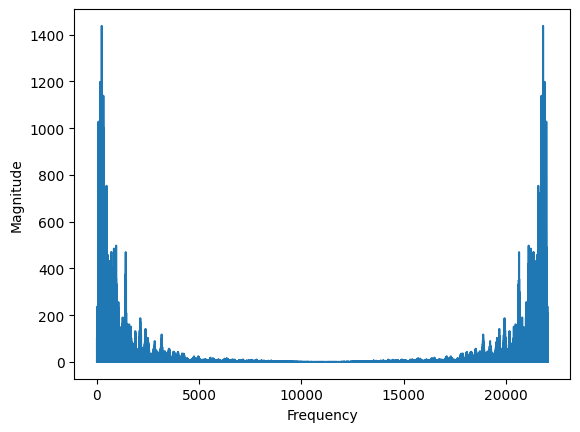

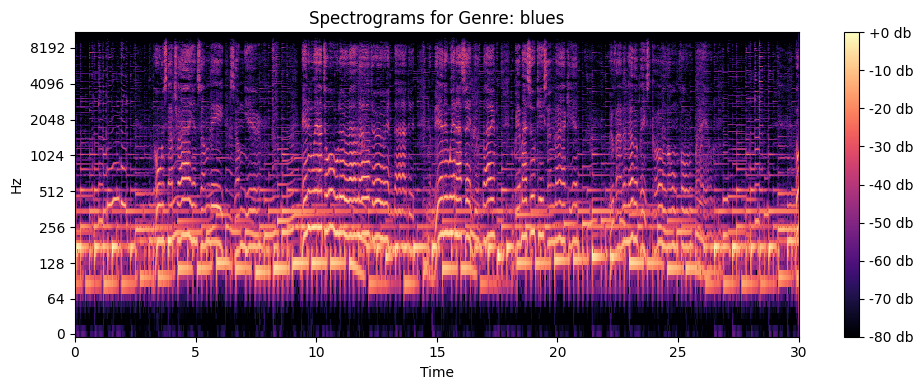

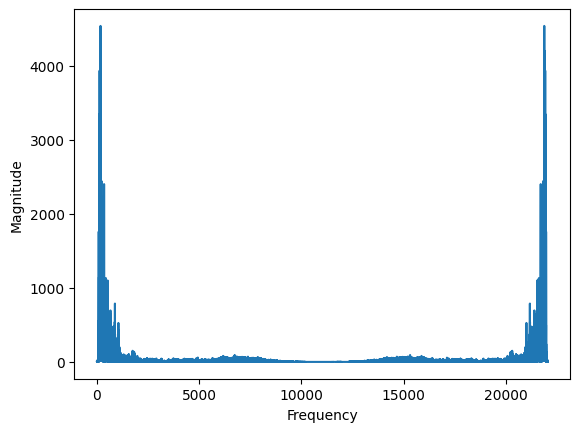

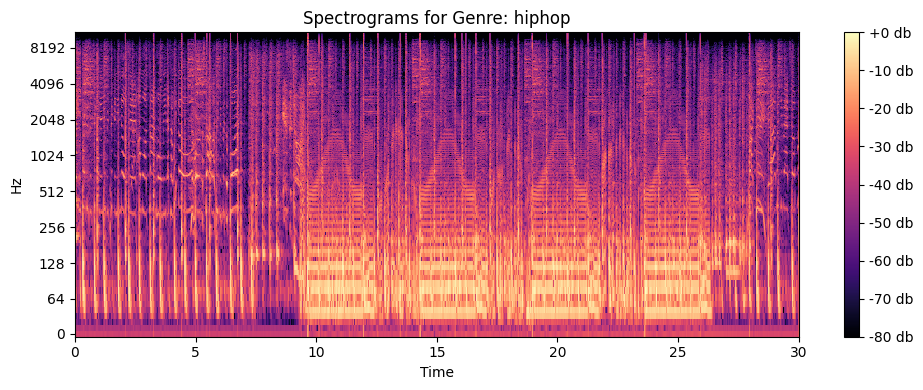

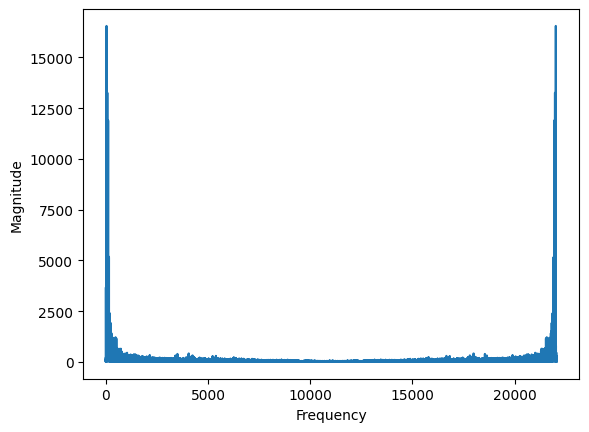

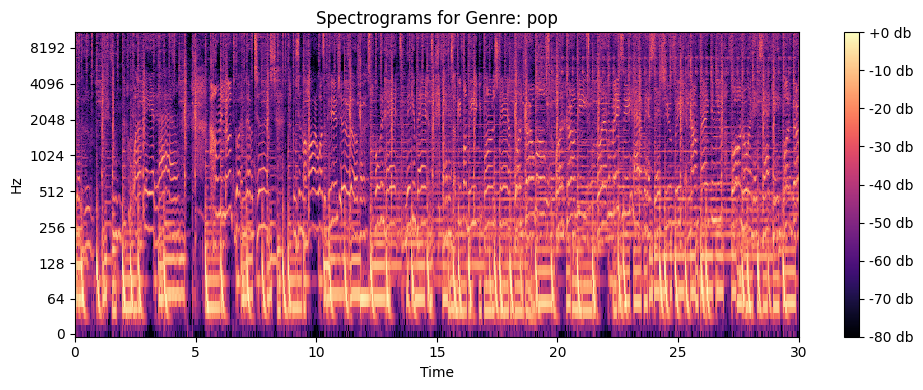

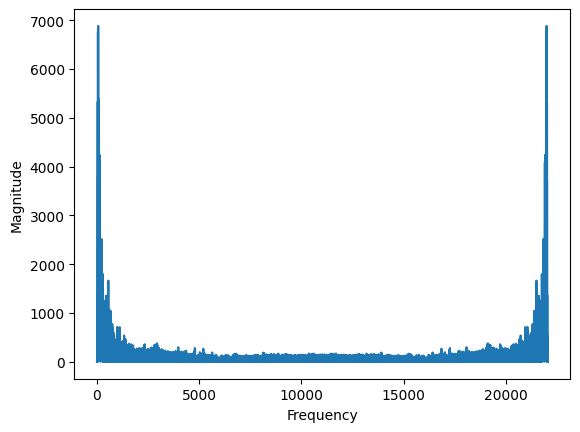

In [7]:
def extract_spectogram(audio_file):
  y, sr = librosa.load(audio_file, sr=22050)
  spectogram = librosa.stft(y)
  spectogram = librosa.amplitude_to_db(abs(spectogram), ref=np.max)
  return spectogram, sr, y

def plot_spectograms_for_genre(genre_dir, genre_name):
  plt.figure(figsize=(10, 4))
  plt.title(f'Spectrograms for Genre: {genre_name}')
  plt.xlabel('Time')
  plt.ylabel('Frequency')


  for root, _, files in os.walk(genre_dir):
    for i, file in enumerate(files):
      if i >= 1:
        break

      file_path = os.path.join(root, file)
      spectrogram, sr, y = extract_spectogram(file_path)
      librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='log')
      plt.colorbar(format='%+2.0f db')
      plt.tight_layout()
      plt.show()

      fft = np.fft.fft(y)
      magnitude = np.abs(fft)
      frequency = np.linspace(0, sr, len(magnitude))
      plt.plot(frequency, magnitude)
      plt.xlabel('Frequency')
      plt.ylabel('Magnitude')
      plt.show()

genre_names = os.listdir(filepath)

for genre_name in genre_names:
  genre_dir = os.path.join(filepath, genre_name)
  plot_spectograms_for_genre(genre_dir, genre_name)


In [ ]:
SAMPLE_RATE = 22050
DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

JSON_PATH = 'data.json'

def extract_features(file_path, data, num_segments, i):
    n_mfcc=13
    n_fft=2048
    hop_length=512
    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)

    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    except Exception as e:
        print(f'Error loading file: {file_path}. Skipping...')
        return None

    # Compute the MFCC features
    for s in range(num_segments):
        start_sample = num_samples_per_segment * s
        finish_sample = start_sample + num_samples_per_segment

        mfcc = librosa.feature.mfcc(y=y[start_sample:finish_sample],
                                    sr=sr,
                                    n_fft=n_fft,
                                    n_mfcc=n_mfcc,
                                    hop_length=hop_length)
        mfcc = mfcc.T

        if len(mfcc) == expected_num_mfcc_vectors_per_segment and mfcc is not None:
          data['mfcc'].append(mfcc.tolist())
          data['labels'].append(i-1)
          print("{}, segment: {}".format(file_path, s+1))

def save_mfcc(dataset_path, json_path, num_segments=5):
  data = {
      "mapping": [],
      "mfcc": [],
      "labels": []
  }

  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
    if dirpath is not dataset_path:
      dirpath_components = dirpath.split(".")
      semantic_label = dirpath_components[-1]
      data['mapping'].append(semantic_label)
      print('\nProcessing {}'.format(semantic_label))

      for file in filenames:
        file_path = os.path.join(dirpath, file)
        extract_features(file_path, data, num_segments, i)

  with open(json_path, 'w') as fp:
    json.dump(data, fp, indent=4)

if __name__ == '__main__':
  save_mfcc(filepath, JSON_PATH, num_segments=20)



In [9]:
def load_data(filepath):
  with open(filepath, 'r') as fp:
    data = json.load(fp)

  inputs = np.array(data['mfcc'])
  targets = np.array(data['labels'])

  return inputs, targets

In [10]:
json_file_path = '/content/data.json'
inputs, targets = load_data(json_file_path)


In [11]:
print(inputs.shape[1])

65


**Train Test Split**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.3, random_state=42)

### **Modelling**

ANN Model

In [13]:
model = Sequential()
model.add(Flatten(input_shape=(inputs.shape[1], inputs.shape[2])))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 845)               0         
                                                                 
 dense (Dense)               (None, 512)               433152    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [14]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Epoch 1/100
437/437 [==============================] - 8s 4ms/step - loss: 13.7280 - accuracy: 0.1442 - val_loss: 3.3533 - val_accuracy: 0.1104
Epoch 2/100
437/437 [==============================] - 2s 4ms/step - loss: 3.9089 - accuracy: 0.1154 - val_loss: 3.3543 - val_accuracy: 0.1044
Epoch 3/100
437/437 [==============================] - 2s 4ms/step - loss: 3.5087 - accuracy: 0.1193 - val_loss: 3.3280 - val_accuracy: 0.1159
Epoch 4/100
437/437 [==============================] - 2s 4ms/step - loss: 3.4189 - accuracy: 0.1249 - val_loss: 3.3059 - val_accuracy: 0.1338
Epoch 5/100
437/437 [==============================] - 2s 4ms/step - loss: 3.3358 - accuracy: 0.1451 - val_loss: 3.2348 - val_accuracy: 0.1622
Epoch 6/100
437/437 [==============================] - 2s 4ms/step - loss: 3.3013 - accuracy: 0.1519 - val_loss: 3.1883 - val_accuracy: 0.1702
Epoch 7/100
437/437 [==============================] - 2s 4ms/step - loss: 3.2514 - accuracy: 0.1571 - val_loss: 3.1639 - val_accuracy: 0.177

In [15]:
def plot_history(history):
  fig, ax = plt.subplots(2)

  ax[0].plot(history.history['accuracy'], label='train_accuracy')
  ax[0].plot(history.history['val_accuracy'], label='test_accuracy')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend(loc='lower right')
  ax[0].set_title('Accuracy eval')

  ax[1].plot(history.history['loss'], label='train_loss')
  ax[1].plot(history.history['val_loss'], label='test_loss')
  ax[1].set_ylabel('Loss')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(loc='upper right')
  ax[1].set_title('Loss eval')

  plt.show()



CNN Model

In [16]:
json_file_path = '/content/data.json'

def load_data(filepath):
  with open(filepath, 'r') as fp:
    data = json.load(fp)

  X = np.array(data['mfcc'])
  y = np.array(data['labels'])

  return X, y

def prepare_dataset(test_size, validation_size):
  X, y = load_data(json_file_path)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size)

  X_train = X_train[..., np.newaxis]
  X_val = X_val[..., np.newaxis]
  X_test = X_test[..., np.newaxis]

  return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.25, 0.2)



In [17]:
def build_model(input_shape):

  model = Sequential()
  model.add(Conv2D(200, (3, 3), input_shape=(input_shape)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
  # model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Conv2D(200, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
  # model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Conv2D(200, (2, 2)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
  # model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(200) )
  # model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation='softmax'))

  return model

In [18]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

model = build_model(input_shape)
model.summary()

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=50,
    decay_rate = 0.9)

optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 63, 11, 200)       2000      
                                                                 
 activation (Activation)     (None, 63, 11, 200)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 6, 200)       0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 32, 6, 200)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 4, 200)        360200    
                                                                 
 activation_1 (Activation)   (None, 30, 4, 200)        0         
                                                      

In [19]:
# data_augmentation = ImageDataGenerator(
#     rotation_range=20,
# #     width_shift_range=0.2,
# #     height_shift_range=0.2,
# #     shear_range=0.2,
# #     zoom_range=0.2,
# #     horizontal_flip=True,
# #     fill_mode='nearest'
# )

# train_generator = data_augmentation.flow(X_train, y_train, batch_size=64)

history = model.fit(
    X_train,
    y_train,
    # train_generator,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=1000,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=30)])

Epoch 1/1000
188/188 [==============================] - 9s 8ms/step - loss: 8.0495 - accuracy: 0.1212 - val_loss: 2.1433 - val_accuracy: 0.2439
Epoch 2/1000
188/188 [==============================] - 1s 6ms/step - loss: 3.7764 - accuracy: 0.1401 - val_loss: 2.1451 - val_accuracy: 0.2503
Epoch 3/1000
188/188 [==============================] - 1s 6ms/step - loss: 2.8883 - accuracy: 0.1495 - val_loss: 2.1482 - val_accuracy: 0.2749
Epoch 4/1000
188/188 [==============================] - 1s 6ms/step - loss: 2.5468 - accuracy: 0.1718 - val_loss: 2.1429 - val_accuracy: 0.2970
Epoch 5/1000
188/188 [==============================] - 1s 6ms/step - loss: 2.3915 - accuracy: 0.1849 - val_loss: 2.1257 - val_accuracy: 0.3016
Epoch 6/1000
188/188 [==============================] - 1s 6ms/step - loss: 2.2789 - accuracy: 0.2052 - val_loss: 2.1029 - val_accuracy: 0.3170
Epoch 7/1000
188/188 [==============================] - 1s 6ms/step - loss: 2.2050 - accuracy: 0.2178 - val_loss: 2.0767 - val_accuracy:

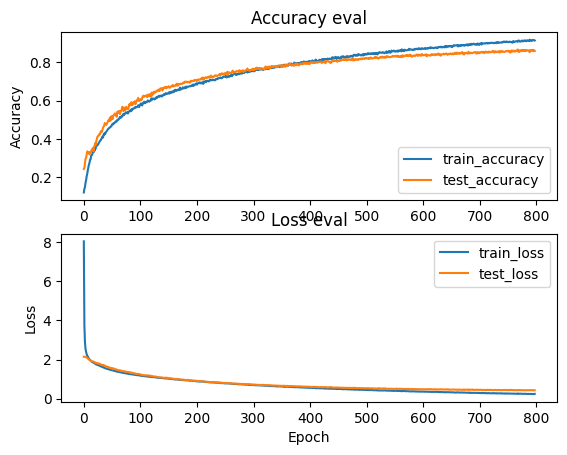

In [20]:
plot_history(history)

In [21]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy on test set is {}'.format(test_accuracy))

157/157 [==============================] - 0s 2ms/step - loss: 0.4568 - accuracy: 0.8543
Accuracy on test set is 0.8542542457580566


In [22]:
def predict(X, y):
  X = X[np.newaxis, ...]
  pred = model.predict(X)
  pred_index = np.argmax(pred, axis=1)
  print('Expected index: {}, Predicted index: {}'.format(y, pred_index))


In [23]:
X = X_test[300]
y = y_test[300]

predict(X, y)

1/1 [==============================] - 0s 140ms/step
Expected index: 2, Predicted index: [2]


**RNN-LSTM Model**

In [24]:
json_file_path = '/content/data.json'

def load_data(filepath):
  with open(filepath, 'r') as fp:
    data = json.load(fp)

  X = np.array(data['mfcc'])
  y = np.array(data['labels'])

  return X, y

def prepare_dataset(test_size, validation_size):
  X, y = load_data(json_file_path)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size)

  return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.25, 0.2)

In [111]:
def build_model(input_shape):
    # RNN-LSTM model
    model = Sequential()
    model.add(LSTM(200, input_shape=input_shape, return_sequences=True, kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(LSTM(200, return_sequences=True, kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(LSTM(200, kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(200, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    return model

In [112]:
input_shape = (X_train.shape[1], X_train.shape[2])

model = build_model(input_shape)
model.summary()

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_59 (LSTM)              (None, 65, 200)           171200    
                                                                 
 batch_normalization_51 (Bat  (None, 65, 200)          800       
 chNormalization)                                                
                                                                 
 dropout_74 (Dropout)        (None, 65, 200)           0         
                                                                 
 lstm_60 (LSTM)              (None, 65, 200)           320800    
                                                                 
 batch_normalization_52 (Bat  (None, 65, 200)          800       
 chNormalization)                                                
                                                                 
 dropout_75 (Dropout)        (None, 65, 200)         

In [113]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=128,
    epochs=1000,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/1000
94/94 [==============================] - 11s 34ms/step - loss: 18.4937 - accuracy: 0.2130 - val_loss: 17.4418 - val_accuracy: 0.4117
Epoch 2/1000
94/94 [==============================] - 2s 21ms/step - loss: 17.2731 - accuracy: 0.3345 - val_loss: 16.3859 - val_accuracy: 0.4892
Epoch 3/1000
94/94 [==============================] - 2s 21ms/step - loss: 16.3742 - accuracy: 0.3759 - val_loss: 15.4987 - val_accuracy: 0.5285
Epoch 4/1000
94/94 [==============================] - 2s 22ms/step - loss: 15.4966 - accuracy: 0.4198 - val_loss: 14.7131 - val_accuracy: 0.5492
Epoch 5/1000
94/94 [==============================] - 2s 21ms/step - loss: 14.6798 - accuracy: 0.4536 - val_loss: 13.9413 - val_accuracy: 0.5749
Epoch 6/1000
94/94 [==============================] - 2s 21ms/step - loss: 13.8739 - accuracy: 0.4803 - val_loss: 13.1953 - val_accuracy: 0.5936
Epoch 7/1000
94/94 [==============================] - 2s 22ms/step - loss: 13.0913 - accuracy: 0.5054 - val_loss: 12.4642 - val_a

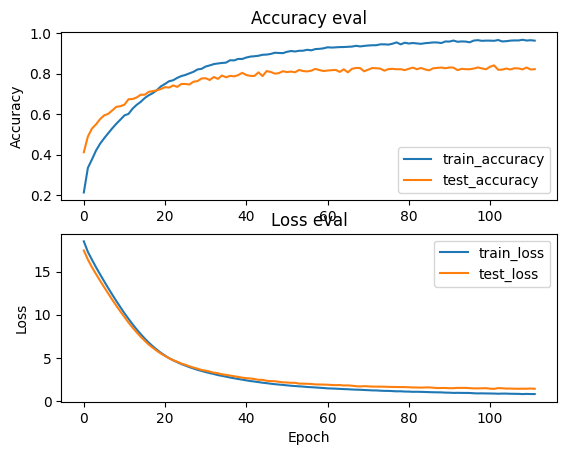

In [114]:
plot_history(history)

In [115]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy on test set is {}'.format(test_accuracy))

157/157 [==============================] - 1s 6ms/step - loss: 1.3590 - accuracy: 0.8310
Accuracy on test set is 0.8310310244560242


In [116]:
def predict(X, y):
  X = X[np.newaxis, ...]
  pred = model.predict(X)
  pred_index = np.argmax(pred, axis=1)
  print('Expected index: {}, Predicted index: {}'.format(y, pred_index))

In [117]:
X = X_test[300]
y = y_test[300]

predict(X, y)

1/1 [==============================] - 1s 932ms/step
Expected index: 1, Predicted index: [1]
